# 

# 第1章　画像分類と転移学習(VGG)

## 1-3 転移学習の実装

転移学習を利用し、蟻と蜂を分類するモデルを作成する。

In [1]:
import glob
import json
import os
import os.path as osp
import random
import urllib
import zipfile
from typing import Any, Callable, Literal, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import models, transforms
from tqdm import tqdm

INFO:2023-12-09 03:02:03 2058:2058 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
torch.manual_seed(2913)
np.random.seed(2913)
random.seed(2913)

#### データの準備

In [4]:
# source: https://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/make_folders_and_data_downloads.ipynb
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_dir = "./data/"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)
    zip.close()

    os.remove(save_path)

In [5]:
train_file_paths = glob.glob(osp.join(data_dir, "hymenoptera_data/train/**/*.jpg"))
val_file_paths = glob.glob(osp.join(data_dir, "hymenoptera_data/val/**/*.jpg"))

### データセットの作成

書籍ではいきなりデータセットクラスを作成しているが、そもそもなぜpytorchでデータセットが必要なのか、どのような要件を満たす必要があるのかを整理する。書籍でのコードと順番が前後するが、自分なりに分かりやすいように説明を変えてみた。

まず、機械学習では当然データセットが必要になる。そして、データセットはそれぞれ固有のクラスとして表現されるのが自然だろう。pytorchでは、`torch.utils.data.dataset.Dataset`を継承したクラスによってDatasetを作成する。これは抽象クラスであり、`__getitem__`関数をオーバーライドしなくてはならない。`__get__`関数はindexを引数にとり、入力と出力のタプルを戻り値とする。`__len__`関数の実装はオプションだが実装しておくと、後述のDataLoaderで自動でサイズを計算してくれるので、実装した方が良いだろう。

書籍では実装されていないが、`show`関数があると便利なので実装するといいかもしれない。

`HymeopteraDataset`の実装は以下のようになる。引数の`transform`は次のセクションで説明する。

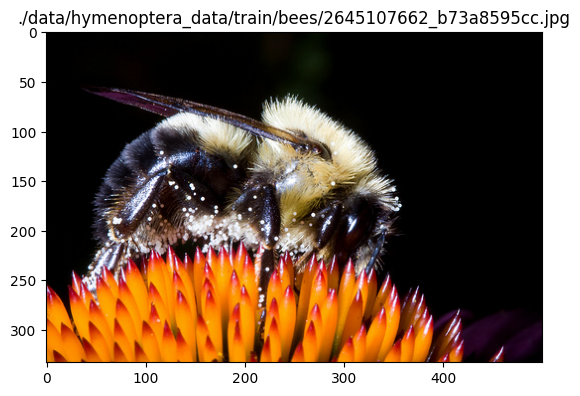

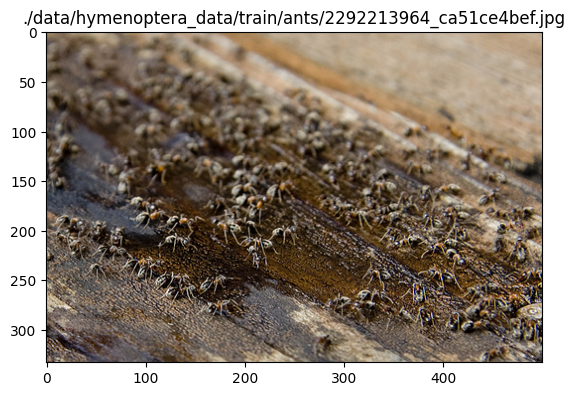

In [6]:
class HymeopteraDataset(Dataset):
    def __init__(
        self, file_paths, transform=None, phase: Literal["train", "test"] = "train"
    ):
        """
        Initializes the HymeopteraDataset class.

        Args:
            file_paths (list): A list of file paths.
            transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version. Defaults to None.
            phase (str, optional): The phase of the dataset. Defaults to "train".
        """
        self.transform = transform
        self.file_paths = file_paths
        self.phase = phase

    def extract_label(self, file_path) -> Literal[0, 1]:
        """
        Extracts the label from the file path.

        Args:
            file_path (str): The file path.

        Returns:
            int: The label (0 for ants, 1 for bees).

        Raises:
            ValueError: If the file path does not contain "ants" or "bees".
        """
        if "ants" in file_path:
            return 0
        elif "bees" in file_path:
            return 1
        else:
            raise ValueError("file_path must contain ants or bees")

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.file_paths)

    def __getitem__(self, index):
        """
        Retrieves an item from the dataset.

        Args:
            index (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and label.
        """
        img_path = self.file_paths[index]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = self.extract_label(img_path)

        return img, label

    def show(self, index):
        """
        Displays an image from the dataset.

        Args:
            index (int): The index of the image to display.
        """
        img, _ = self.__getitem__(index)
        if self.transform:
            # (channel, height, width) -> (height, width, channel)
            img = img.numpy().transpose((1, 2, 0))
            # clip the value to [0, 1]
            img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(self.file_paths[index])
        plt.show()


# simple assertion test
assert (
    HymeopteraDataset(
        ["./data/hymenoptera_data/train/ants/0013035.jpg"], phase="train"
    )[0][1]
    == 0
)
assert (
    HymeopteraDataset(
        ["./data/hymenoptera_data/train/bees/16838648_415acd9e3f.jpg"], phase="train"
    )[0][1]
    == 1
)

HymeopteraDataset(train_file_paths).show(0)
HymeopteraDataset(train_file_paths).show(-1)

### 前処理クラスの作成

データセットには前処理を施したい場合がある。例えば、1-1でやったような標準化・リサイズ・クロップは画像の前処理として必要だし、モデルの訓練時にはランダムクロップやホリゾンタルフリップによるデータオーギュメンテーション(1つのデータを複数のデータに拡張する)も有効である。

このような前処理は、`Dataset`を継承した先の`HymeopteraDataset`の中に実装しても良いとは思う。しかしながら、`HymeopteraDataset`に対する修正はほぼ皆無であるのに対し、前処理の実装は色々と変更を加えたいということもあるだろう。また、[単一責任の原則](https://ja.wikipedia.org/wiki/%E5%8D%98%E4%B8%80%E8%B2%AC%E4%BB%BB%E3%81%AE%E5%8E%9F%E5%89%87)に基づいても、`Dataset`と前処理は分離されている方が自然な気がする。

したがって、下記のように前処理を行う`ImageTransform`を作成し、`HymeopteraDataset`の引数数の`transoform`に渡してやることにする。

In [7]:
class ImageTransform:
    def __init__(self, resize, mean, std):
        """
        Initializes the ImageTransform class.

        Args:
            resize (int): The size to which the image will be resized.
            mean (tuple): The mean values for normalization.
            std (tuple): The standard deviation values for normalization.
        """
        self.data_transform = {
            "train": transforms.Compose(
                [
                    transforms.RandomResizedCrop(
                        resize, scale=(0.5, 1.0)
                    ),  # data augmentation
                    transforms.RandomHorizontalFlip(),  # data augmentation
                    transforms.ToTensor(),  # convert to tensor
                    transforms.Normalize(mean, std),  # normalize
                ]
            ),
            "val": transforms.Compose(
                [
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
        }

    def __call__(self, img, phase="train"):
        """
        Applies the specified data transformation to the input image.

        Args:
            img (PIL.Image): The input image.
            phase (str, optional): The phase of the transformation. Defaults to 'train'.

        Returns:
            torch.Tensor: The transformed image.
        """
        return self.data_transform[phase](img)

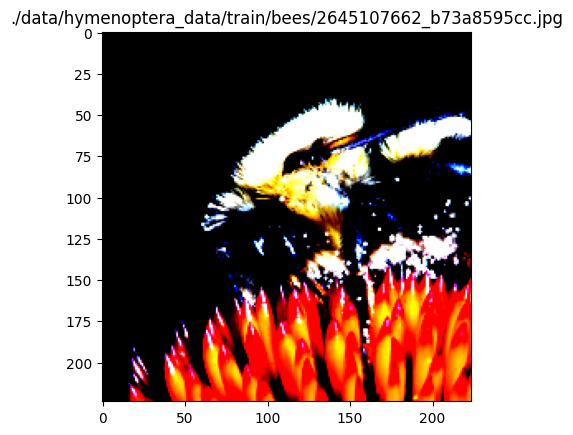

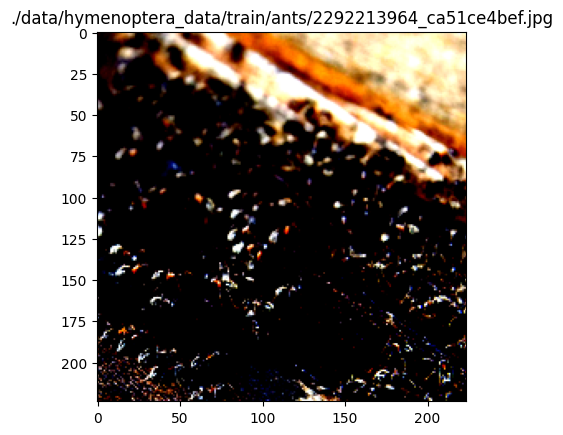

In [8]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)
train_dataset = HymeopteraDataset(train_file_paths, transform=transform, phase="train")
val_dataset = HymeopteraDataset(val_file_paths, transform=transform, phase="val")

train_dataset.show(0)
train_dataset.show(-1)

### DataLoaderの作成

ここまで、前処理とデータセットのクラスを作成してきた。次に、データセットからどのようにデータを取り出すかについて考える。一見、データセットオブジェクトから1つずつ取り出していけばよいように思えるが、機械学習ではバッチサイズの指定ややデータのシャッフルの有無を適切に設定して、データをモデルに読み込ませる。そのため、データの取り出し方はある程度複雑になるので、`DataLoader`を作成した方が良い。

pytorchでは、`torch.utils.data.DataLoader`を使えばよく、特殊な実装は不要。

[公式ドキュメント](https://pytorch.org/docs/stable/data.html#memory-pinning)曰く、`pin_memory=True`とするとGPU環境下で処理が大幅に速くなるとのことなので、ここでは設定しておく。

In [9]:
batch_size = 32
num_workers = min(os.cpu_count(), 2)
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
)
val_dataloader = data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=num_workers,
)

### ネットワークモデルの作成

1-1とここは同じ。学習させるので、`eval()`は使用しない。

なお、`models.vgg16`で取得できる`VGG`クラスは、`torch.nn.Module`クラスを継承しており、以下のように`__getattr__`が定義されている。

```python
    def __getattr__(self, name: str) -> Union[Tensor, 'Module']:
        if '_parameters' in self.__dict__:
            _parameters = self.__dict__['_parameters']
            if name in _parameters:
                return _parameters[name]
        if '_buffers' in self.__dict__:
            _buffers = self.__dict__['_buffers']
            if name in _buffers:
                return _buffers[name]
        if '_modules' in self.__dict__:
            modules = self.__dict__['_modules']
            if name in modules:
                return modules[name]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, name))
```

`_modules`にはモデルを構成する`Module`クラスがOrdered Dictとして格納されている。

`__getattr__`により、`models.classifier[6]`のような形でアクセスできる。

In [10]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [00:21<00:00, 26.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
print(model._modules)

OrderedDict([('features', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): 

classifierの`(6): Linear(in_features=4096, out_features=1000, bias=True)`の部分で、out_featuresを2に変えてあげれば良い。

モデルは学習モードに変更する必要あり。

In [12]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 損失関数を定義

クラス分類なので、損失関数はクロスエントロピー誤差関数とする。名前の通り、平均情報量(エントロピー)の係数部分を正解値に書き換えたものになる。

- [交差エントロピー誤差をわかりやすく説明してみる](https://qiita.com/kenta1984/items/59a9ef1788e6934fd962)
- [平均情報量    Entropy](https://www.mnc.toho-u.ac.jp/v-lab/yobology/entropy/entropy.htm)

In [13]:
criterion = nn.CrossEntropyLoss()
type(criterion)

torch.nn.modules.loss.CrossEntropyLoss

### 最適化手法を設定

最適化時に、パラメータの更新の有無を設定することができる。

`named_parameters`を使うと、dictに対する`items`のような感じでnameとparameterを取得できる。

今回は転移学習なので、最後の層のみパラメータを更新すれば良い。まず、最後の層の更新すべきパラメータを確認する。

In [14]:
model.classifier[6]._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[ 0.0075, -0.0019, -0.0064,  ...,  0.0117, -0.0031, -0.0123],
                      [ 0.0018,  0.0024, -0.0090,  ..., -0.0122,  0.0155, -0.0031]],
                     requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([-0.0074,  0.0128], requires_grad=True))])

In [15]:
for name, param in model.named_parameters():
    param.requires_grad = False
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

In [16]:
optmizer = optim.SGD(params=model.classifier[6].parameters(), lr=1e-3, momentum=0.9)

### 学習・検証を実施

GPUを使用しているので、model、入力、出力は全て`to(device)`でGPUに載せないといけない。載せてないとエラーが出る。

`dataloader`をfor loopで回すと、バッチサイズでまとめてデータが取り出される。ちなみに、データセットのサイズがバッチサイズの整数倍になっていない場合、最後のサイズはバッチサイズと異なることが以下でわかる。

パラメータの更新は以下で行われる。ここら辺の挙動が正直よくわからないが、とりあえずこういうものだと覚えておく。

```python
optmizer.zero_grad()
with torch.set_grad_enabled(phase == "train"):
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    if phase == "train":
        loss.backward()
        optmizer.step()
```

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda', index=0)

In [18]:
len(train_dataloader.dataset)

243

In [19]:
for inputs, labels in train_dataloader:
    print(inputs.size())
    print(labels.size())

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([19, 3, 224, 224])
torch.Size([19])


In [20]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("----------")
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
            dataloader = train_dataloader
        else:
            model.eval()
            dataloader = val_dataloader

        epoch_loss = 0.0
        epoch_corrects = 0

        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optmizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == "train":
                    loss.backward()
                    optmizer.step()

                epoch_loss += loss.item() * inputs.size(0)
                epoch_corrects += torch.sum(preds == labels.data)

        epoch_loss = epoch_loss / len(dataloader.dataset)
        epoch_acc = epoch_corrects.double() / len(dataloader.dataset)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

Epoch 1/10
----------


  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.28it/s]


train Loss: 0.4476 Acc: 0.7819


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


val Loss: 0.1802 Acc: 0.9673
Epoch 2/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]


train Loss: 0.1451 Acc: 0.9465


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


val Loss: 0.1195 Acc: 0.9608
Epoch 3/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.47it/s]


train Loss: 0.1200 Acc: 0.9506


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


val Loss: 0.1203 Acc: 0.9477
Epoch 4/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.10it/s]


train Loss: 0.0897 Acc: 0.9712


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


val Loss: 0.1065 Acc: 0.9673
Epoch 5/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.08it/s]


train Loss: 0.0863 Acc: 0.9630


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


val Loss: 0.1302 Acc: 0.9477
Epoch 6/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.05it/s]


train Loss: 0.0793 Acc: 0.9588


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


val Loss: 0.0917 Acc: 0.9542
Epoch 7/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.46it/s]


train Loss: 0.0847 Acc: 0.9753


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


val Loss: 0.0848 Acc: 0.9608
Epoch 8/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.72it/s]


train Loss: 0.0746 Acc: 0.9712


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


val Loss: 0.0817 Acc: 0.9542
Epoch 9/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.83it/s]


train Loss: 0.0530 Acc: 0.9794


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


val Loss: 0.0797 Acc: 0.9608
Epoch 10/10
----------


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.69it/s]


train Loss: 0.0638 Acc: 0.9794


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]

val Loss: 0.0763 Acc: 0.9673
